<a href="https://colab.research.google.com/github/ShoSato-047/R_review/blob/main/STAT380_1_2_(2025)_Review_of_MLR_interactions_and_interpretations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In the previous notebook we reviewed linear regression models in more of a predictive framework: just trying to model $Y$ as best as possible.   In this notebook we focus more on the interpretability of the MLR model and inference, that is, using p-values and 95% confidence intervals to make statistical decisions about relationships between $Y$ and model terms.

# Case study: neurological impacts of lead exposure
*	Observational study investigating relationship of lead exposure with neurological and psychological well-being of children
*	Blood lead levels (in 𝜇g/mL) determined for group of children near lead smelter in El Paso, TX
*	Two exposure groups identified (variable `Group`):
  *	Group 1: Blood lead levels < 40𝜇g/mL
  *	Group 2: Blood lead levels ≥40 𝜇g/mL
*	Primary outcome: finger-wrist tapping scores, the number of finger-wrist
 taps in the dominant hand (taps in one ten second trial), a measure of
 neurological function (`maxfwt`)
 * Other variables that could explain the FWT score: Age, and "clumsiness", an indicator variable of whether or not the parent deemed their child "clumsy" (source: Rosner).

In [1]:
library(dplyr)
lead <- read.csv('https://www.dropbox.com/s/r84evk7q5nciv94/LEAD.csv?dl=1')  %>%
  select(maxfwt, ageyrs, clumsi, Group,sex) %>%
  filter(!is.na(maxfwt))
head(lead)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,maxfwt,ageyrs,clumsi,Group,sex
,<int>,<dbl>,<chr>,<chr>,<chr>
1,72,11.08,No,<40,M
2,61,9.42,No,<40,M
3,49,11.08,No,<40,M
4,48,6.92,No,<40,M
5,51,11.25,No,<40,M
6,49,6.50,No,<40,M


Exploring the response variable:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


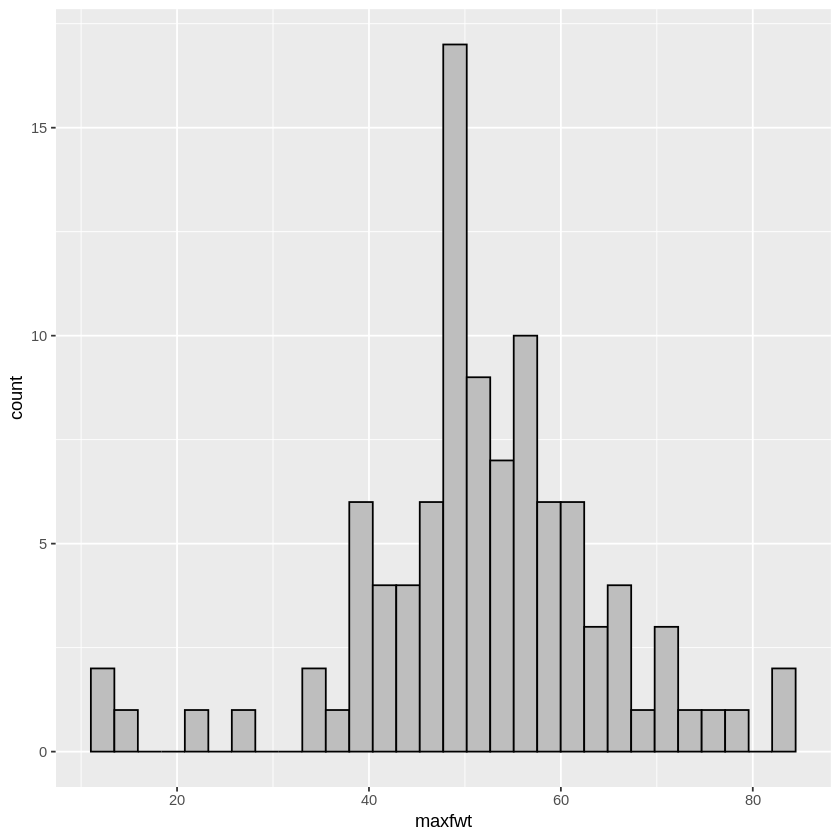

In [2]:
library(ggplot2)
ggplot(data = lead) +
  geom_histogram(aes(x = maxfwt), col = 'black', fill = 'grey')

No drastic skew in the distribution, although there are a few outliers on the low end.

# Lead ⟶ FWT score, by clumsiness

Consider the following questions:

* Is there a relationship between lead exposure and FWT score?
* Does this relationship depend upon whether or not the child is deemed "clumsy" by their parents?

## Exploring the relationship visually

Creating some graphs to visualize this relationship:

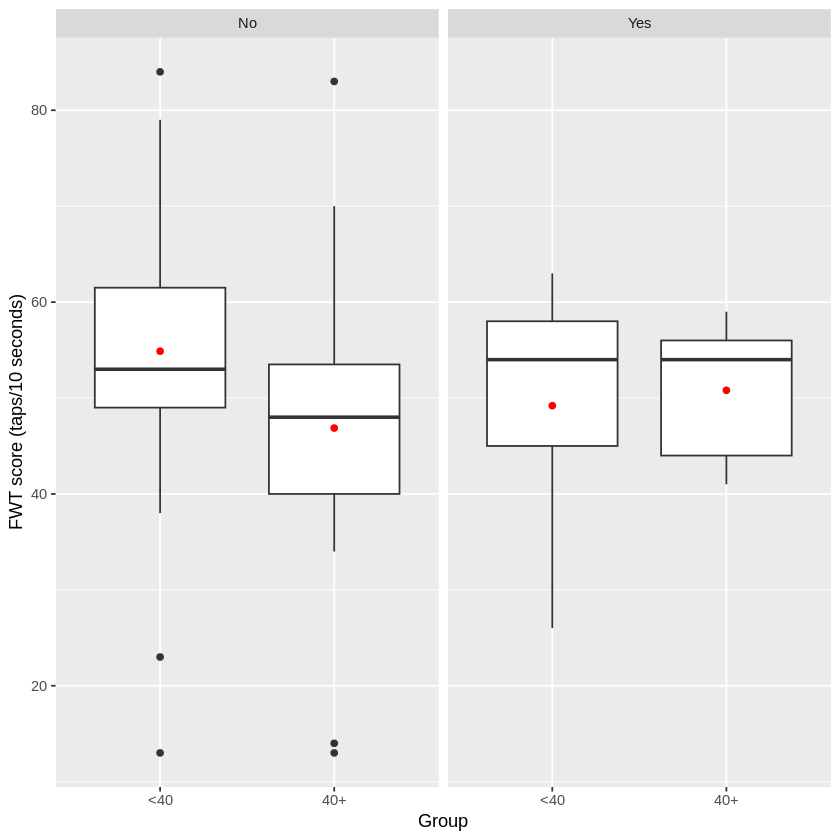

In [ ]:
ggplot(data = lead,aes(x = Group, y = maxfwt)) +
  geom_boxplot() +
  stat_summary(fun='mean', col='red',geom='point') +
    ylab('FWT score (taps/10 seconds)') +
    facet_wrap(~clumsi)

In [ ]:
# Getting the means and sample sizes and plotting just the mean relationship
mean.fwt.scores <- (lead
  %>% summarize(avg.fwt = mean(maxfwt), sampsize =  n(), .by = c(Group, clumsi) )
)

In [ ]:
mean.fwt.scores

Group,clumsi,avg.fwt,sampsize
<chr>,<chr>,<dbl>,<int>
<40,No,54.88136,59
<40,Yes,49.20000,5
40+,Yes,50.80000,5
40+,No,46.86667,30


In [ ]:
options(repr.plot.width = 9, repr.plot.height= 7)

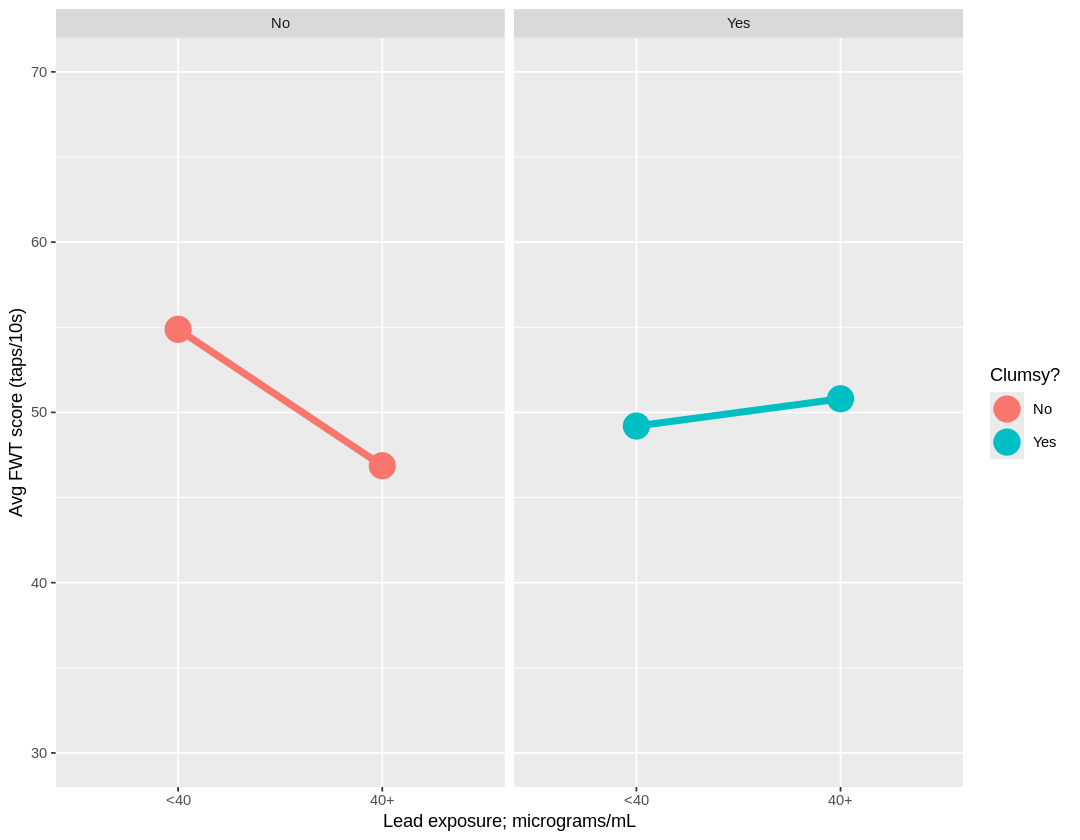

In [ ]:
ggplot(data = mean.fwt.scores, aes(x = Group, y = avg.fwt, col = clumsi)) +
  geom_point(size = 7) +
  geom_line(aes(group = clumsi),linewidth = 2) +
  facet_wrap(~clumsi) +
    ylim(c(30,70)) +
    ylab('Avg FWT score (taps/10s)') +
    xlab('Lead exposure; micrograms/mL')+
    scale_color_discrete(name = 'Clumsy?')

Comments:

In [ ]:
# For non-clumsy kids, the average FWT score appears lower with high lead exposure than with low lead exposure.
# This relationship appears to reverse for the clumsy kids, although their FWT scores are much more similar.

## The MLR model with interaction

For our study we have the following MLR model with terms involving dummy variables and an interaction:

$$E(Y|X_1,X_2) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1\cdot X_2$$

* $X_1 = \begin{cases}1; & \mbox{lead exposure} \geq 40 \\
0; & \mbox{lead exposure} < 40 \end{cases}$


* $X_2 = \begin{cases}1; & \mbox{clumsy}  \\
0; & \mbox{not clumsy} \end{cases}$

Note the $E()$ notation for this model, which reads "The expected value (aka *average*) of $Y$ given terms $X_1$ and $X_2$."

As a function of the regression parameters (the $\beta$'s), define:

* Average FWT for not clumsy children in the low exposure group
  - $\beta_0$
* Average FWT for not clumsy children in the high exposure group
  - $\beta_0$ + $\beta_1$ $\cdot 1 = \beta_0$ + $\beta_1$
* What is the difference in average maxfwt scores comparing *high exposure* to *low exposure* children ***who are not clumsy***?
  - $(\beta_0 + \beta_1) - \beta_0 = \beta_1$

As a function of the regression parameters, define:

* Average FWT for clumsy children in the low exposure group
* Average FWT for  clumsy children in the high exposure group
* What is the difference in average maxfst comparing *high exposure* to *low exposure* children ***who are clumsy***?
  - $\beta_1$ + $\beta_3$

In summary:

* Difference in mean FWT comparing *high exposure* to *low exposure* children ***who are clumsy***:

$$\beta_1 + \beta_3$$

* Difference in mean FWT comparing *high exposure* to *low exposure* children ***who are not clumsy***:

$$\beta_1$$

* Difference in differences: how much weaker/stronger the lead exposure effect is, comparing clumsy to non-clumsy children:

$$\beta_3$$


Fitting the model in R:

In [ ]:
group_clumsi_fit <- lm(maxfwt~Group + clumsi+Group*clumsi, data = lead)
summary(group_clumsi_fit)


Call:
lm(formula = maxfwt ~ Group + clumsi + Group * clumsi, data = lead)

Residuals:
    Min      1Q  Median      3Q     Max 
-41.881  -6.341   1.119   7.119  36.133 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          54.881      1.626  33.743  < 2e-16 ***
Group40+             -8.015      2.801  -2.861  0.00519 ** 
clumsiYes            -5.681      5.819  -0.976  0.33137    
Group40+:clumsiYes    9.615      8.383   1.147  0.25430    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 12.49 on 95 degrees of freedom
Multiple R-squared:  0.08212,	Adjusted R-squared:  0.05314 
F-statistic: 2.833 on 3 and 95 DF,  p-value: 0.04238


Taking a look at the model matrix (conversion of variables to terms):

In [ ]:
model.matrix(group_clumsi_fit)[59:70,]

,(Intercept),Group40+,clumsiYes,Group40+:clumsiYes
59,1,0,0,0
60,1,0,0,0
61,1,0,0,0
62,1,0,0,0
63,1,1,1,1
64,1,1,0,0
65,1,1,0,0
66,1,1,1,1
67,1,1,0,0
68,1,1,0,0


Obtaining the 95% confidence intervals for the coefficients:

In [ ]:
confint(group_clumsi_fit)

,2.5 %,97.5 %
(Intercept),51.652433,58.110279
Group40+,-13.576191,-2.453187
clumsiYes,-17.233503,5.870791
Group40+:clumsiYes,-7.028105,26.257484


## Interpreting the interaction model

* $\hat\beta_0$: ***Among non-clumsy children***, the average FWT score is 54.9 points among children with < 40 mg/mL lead exposure:


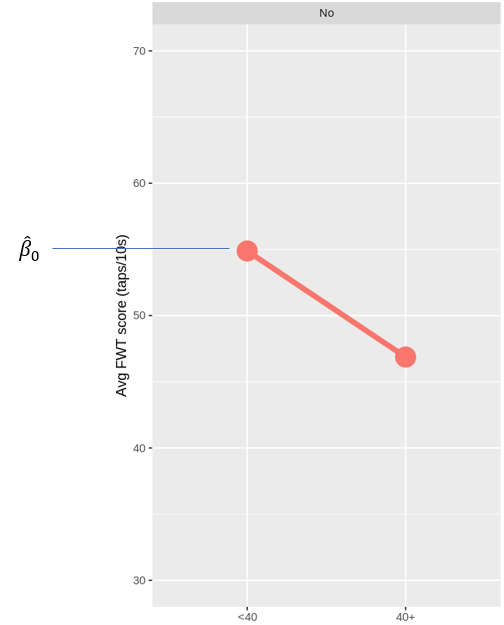

In [3]:
# take negative sign and put it into Englsih "lower" instead


* $\hat\beta_1$:  ***Among non-clumsy children***, the average FWT score is 8.0 points lower for children with high lead exposure compared to children with low lead exposure
  - This is a statistically significant difference (p-value = 0.009; 95% CI: 2.5, 13.6); evidence to support $\beta_1 \ne 0$.
  

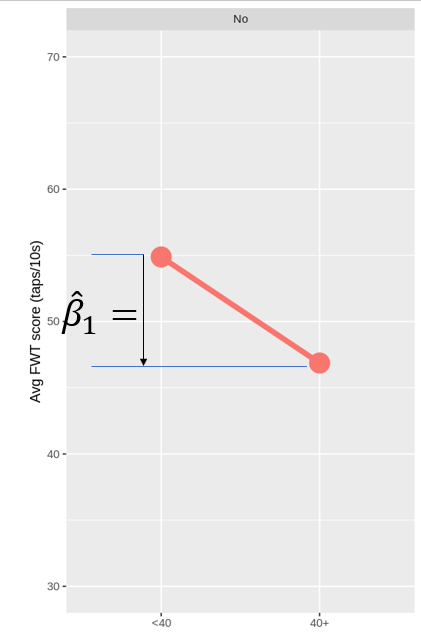


* $\hat\beta_2$:  ***In the low exposure group***, the average FWT score is 5.7 points lower for clumsy children than for non-clumsy children.
    - This is a NOT, however, a statistically significant difference (p-value = 0.331; 95% CI: -17.2, 5.9); no evidence to support $\beta_2 \ne 0$.
    

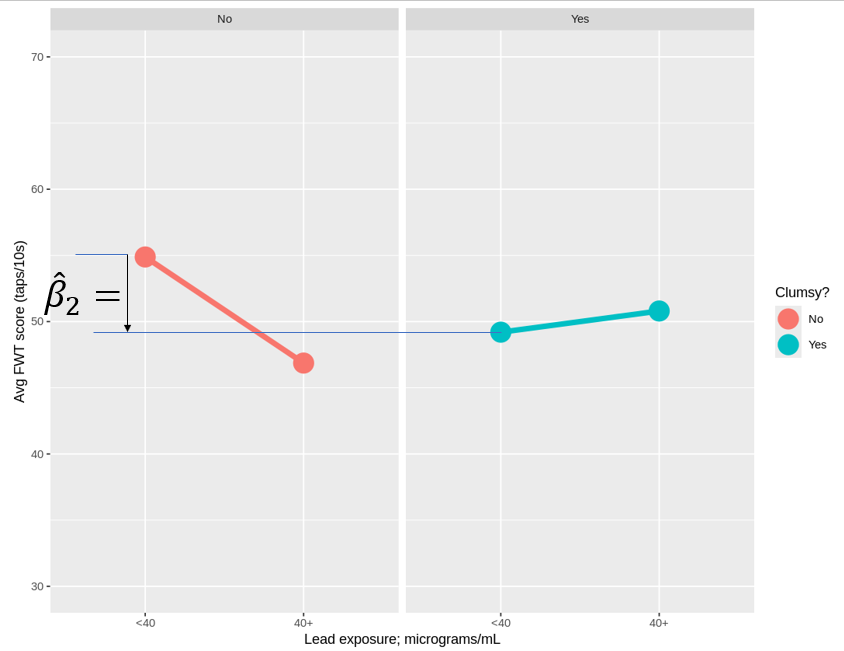

* $\hat\beta_3$: ***Change in lead effect***-  The difference between high-and-low exposure groups for the **clumsy children** is 9.6 difference-in-points larger than the difference between high-and-low exposure groups for the **not clumsy children**.
  - Note this is a bit meaningless out-of-context, since this actually *weakens* the lead exposure effect (started out at -8.0).
  -  There is no statistically significant evidence that the effect of exposure on FWT differs between clumsy and non-clumsy children (p-value = 0.28; 95% CI: -7.0, 26.3).  
  - This is likely due to lack of power: 95% CI is centered away from 0; will narrow with larger n (some of the Group/Clumsiness combinations are quite small).

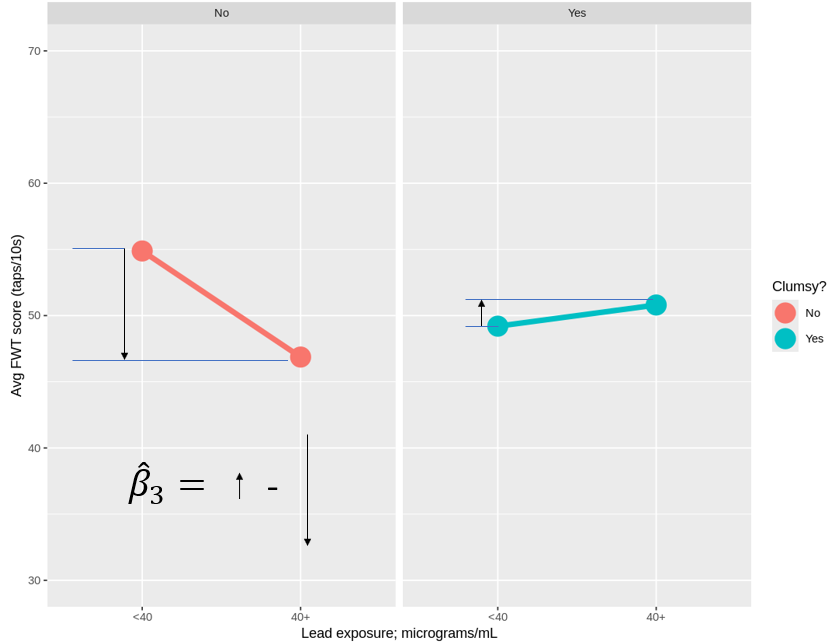


* $\hat\beta_1 + \hat\beta_3$: ***Among clumsy children***, the average FWT score is (-8.0 + 9.6) = 1.6 points higher for children with high lead exposure compared to children with low lead exposure
  - We don't have a p-value/95% CI for this *sum of coefficients*, only the individual coefficients.  We'll get there, in the next notebook.
  





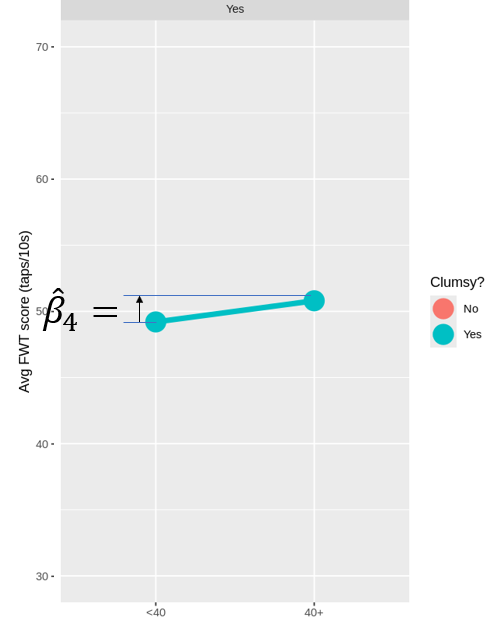

# Motivating `emmeans`

* The `summary(model)` output shows us limited information about differences between groups.
* If we want to test more nuanced contrasts, such as the impact of lead exposure among clumsy children, we need to be able to test hypotheses about linear combinations of the parameters.  That's the topic of the next notebook.
